<a href="https://colab.research.google.com/github/pushyag1/NLPClass/blob/master/chatbot_covid_executed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Notebook Configuration

In [28]:
%matplotlib inline

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

def pprint(o):
    # small helper to make dict dumps a bit prettier
    print(json.dumps(o, indent=2))

# Installation of Rasa

In [29]:
import sys
python = sys.executable

#!{python} -m pip install -U rasa_core==0.9.6 rasa_nlu[spacy]===0.12.3; #rasa_core==0.9.6 doesn't work anymore, so are used new updated versions
!{python} -m pip install -U rasa_core==0.11.12 rasa_nlu[spacy]===0.13.6;
!{python} -m pip install sklearn_crfsuite;

# as well as install a language model:
!{python} -m spacy download en_core_web_md
!{python} -m spacy link en_core_web_md en --force;

Requirement already up-to-date: rasa_core==0.11.12 in /usr/local/lib/python3.6/dist-packages (0.11.12)
Requirement already up-to-date: rasa_nlu[spacy]===0.13.6 in /usr/local/lib/python3.6/dist-packages (0.13.6)
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_md -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


test the installation - we should have rasa_nlu: 0.12.3 and rasa_core: 0.9.6 installed, and spacy model should be available.

In [30]:
import rasa_nlu
import rasa_core
import spacy

print("rasa_nlu: {} rasa_core: {}".format(rasa_nlu.__version__, rasa_core.__version__))
print("Loading spaCy language model...")
print(spacy.load("en")("Hello world!"))

rasa_nlu: 0.13.6 rasa_core: 0.11.12
Loading spaCy language model...
Hello world!


### Some additional Tools needed
To do some of the visualizations you will also need graphviz. If you don't have graphviz installed, and this doesn't work: don't worry. I'll show you the graph and besides that visualization everything else will work.

Try installing with anyone of these (or adapt to your operating system):

In [31]:
!apt-get -qq install -y graphviz libgraphviz-dev pkg-config;



In [32]:
!{python} -m pip install pygraphviz;

In [33]:
!pip install graphviz

In [34]:
!breq install graphviz

/bin/bash: breq: command not found


In [35]:
!pip install rasa_nlu

In [36]:

!{python} -m pip install pygraphviz;

In [37]:
!pip install rasa_nlu

#Part 1: Natural Language Understanding
At first, let's teach our chatbot how to understand user inputs. To do that, we are going to build a Rasa NLU model. Here is some data to get started:

Conversation_1:

U: Hello

B: Hello, how are you doing?

U: I am doing great!

B: Great. Carry on!

Conversation_2:

U: Hey

B: Hello, how are you doing?


In [38]:
nlu_md = """
## intent:greet
- hey
- hello there
- hi
- hello
- good morning
- good evening
- hey there
- let's go
- hey dude
- goodmorning
- goodevening
- good afternoon

## intent:affirm
- great
- OK
- okay
- thank you
- thanks
- yes, thanks
- cheers
- thanks a lot
- thank you very much

## intent:Coronavirus_Definition
- What is a coronavirus?
- What is COVID-19?
- What do you mean by coronavirus?
- Could you help me with COVID-19 meaning?
- Tell me the definition of Coronavirus


## intent:Coronavirus_Symptoms
- What are the symptoms of COVID-19?
- Please tell me the symptoms of Coronavirus?
- How does coronavirus symptoms look like?
- What would indicate I have coronavirus?
- Coronavirus symptoms list please.


## intent:Coronavirus_spread
- How does COVID-19 spread?
- Can the virus that causes COVID-19 be transmitted through the air?
- Can CoVID-19 be caught from a person who has no symptoms?
- Can I catch COVID-19 from the feces of someone with the disease?
- Can the coronavirus spread through air?

## intent:Coronavirus_Protection
- What can I do to protect myself and prevent the spread of disease?
- What can I do to protect myself andProtection measures for persons who are in or have recently visited (past 14 days) areas where COVID-19 is spreading prevent the spread of disease?
- Protection measures for persons who are in or have recently visited (past 14 days) areas where COVID-19 is spreading
- How to protect myself from Coronavirus?
- Protective measures for coronavirus please.

## intent:Coronavirus_Risk
- How likely am I to catch COVID-19?
- How likely am I to catch Coronavirus?
- Should I worry about COVID-19
- Who is at risk of developing severe illness?
- What are my chances of getting COVID-19?


## intent:Coronavirus_Antibiotics
- Are antibiotics effective in preventing or treating the COVID-19?
- Can I use antibiotics for Covid?
- How about Antibiotics for treatment?
- Effect of antibiotics for Coronavirus?
- Antibiotics role in covid treatment?

## intent:google_link
 - send more information about coronavirus
 - more information about COVID-19
 - details about COVID-19
 - details about coronavirus
 - send me a link for coronavirus details
 - more details 
 - more information
 - tell me more about covid-19

## intent:Coronavirus_Medicine
- Are there any medicines or therapies that can prevent or cure COVID-19?
- Is there a vaccine, drug or treatment for COVID-19?
- Could you suggest any medicine for Covid?
- Medicine for coronavirus?
- Treatment for Covid?
- is there a vaccine for covid?
- corona virus vaccination
- when will the vaccination be available?

## intent:Coronavirus_Mask
- Should I wear a mask to protect myself
- How masks are helpful for COVID-19?
- Are masks mandatory?
- Please tell me about masks for Covid.
- What about masks?
- Is it safe to wear a mask during physical activities?

## intent:Coronavirus_PregnantWomen
- Are pregnant women at higher risk from COVID-19?
- I'm pregnant. How can I protect myself against COVID-19?
- Should pregnant women be tested for COVID-19?
- Can COVID-19 be passed from a woman to her unborn baby?
- What care should be available during pregnancy and childbirth?
- Do pregnant women with suspected or confirmed COVID-19 need to give birth by ceasarean section?


## intent:Coronavirus_Influenza
- How are COVID-19 and influenza viruses similar?
- How are COVID-19 and influenza viruses different?
- What medical interventions are available for COVID-19 and influenza viruses?

## intent: inform
- [corona](group:COVID-19)
- [COVID](group:COVID-19)
- [cornoavirus](group:COVID-19)
- a [COVID-19](group:COVID-19)
- [more measures](group:COVID precautions)


"""

%store nlu_md > nlu.md

Writing 'nlu_md' (str) to file 'nlu.md'.


In [39]:
config = """
language: "en"

pipeline:
- name: "nlp_spacy"                   # loads the spacy language model
- name: "tokenizer_spacy"             # splits the sentence into tokens
- name: "ner_crf"                   # uses the pretrained spacy NER model
- name: "intent_featurizer_spacy"     # transform the sentence into a vector representation
- name: "intent_classifier_sklearn"   # uses the vector representation to classify using SVM
- name: "ner_synonyms"                # trains the synonyms
""" 

%store config > config.yml

Writing 'config' (str) to file 'config.yml'.


#Training the Rasa NLU Model
We're going to train a model to recognise user inputs, so that when you send a message like "hello" to your bot, it will recognise this as a "greet" intent.

In [40]:

from rasa_nlu.training_data import load_data
from rasa_nlu.config import RasaNLUModelConfig
from rasa_nlu.model import Trainer
from rasa_nlu import config

In [41]:
# loading the nlu training samples
training_data = load_data("nlu.md")

# trainer to educate our pipeline
trainer = Trainer(config.load("config.yml"))

# train the model!
interpreter = trainer.train(training_data)

# store it for future use
model_directory = trainer.persist("./models/nlu", fixed_model_name="current")

INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 83 (14 distinct intents)
	- Found intents: 'google_link', 'Coronavirus_Antibiotics', 'greet', 'inform', 'Coronavirus_Protection', 'affirm', 'Coronavirus_Risk', 'Coronavirus_PregnantWomen', 'Coronavirus_Symptoms', 'Coronavirus_Mask', 'Coronavirus_Definition', 'Coronavirus_spread', 'Coronavirus_Medicine', 'Coronavirus_Influenza'
	- entity examples: 5 (1 distinct entities)
	- found entities: 'group'

INFO:rasa_nlu.utils.spacy_utils:Trying to load spacy model with name 'en'
INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.model:Starting to train component nlp_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component tokenizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component ner_crf
INFO:rasa

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.2s finished
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component ner_synonyms
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Successfully saved model into '/content/models/nlu/default/current'


#Using & evaluating the NLU model
Let's see how the model is performing on some of the inputs:

In [42]:
pprint(interpreter.parse("what has to be done to prevent covid"))

{
  "intent": {
    "name": "Coronavirus_Protection",
    "confidence": 0.1851301485881949
  },
  "entities": [],
  "intent_ranking": [
    {
      "name": "Coronavirus_Protection",
      "confidence": 0.1851301485881949
    },
    {
      "name": "Coronavirus_Risk",
      "confidence": 0.10620755133059022
    },
    {
      "name": "Coronavirus_spread",
      "confidence": 0.09703893847445706
    },
    {
      "name": "Coronavirus_Definition",
      "confidence": 0.0918437110619336
    },
    {
      "name": "greet",
      "confidence": 0.08031656488232648
    },
    {
      "name": "Coronavirus_PregnantWomen",
      "confidence": 0.08013732692481539
    },
    {
      "name": "Coronavirus_Medicine",
      "confidence": 0.06977790427618641
    },
    {
      "name": "inform",
      "confidence": 0.05874965187085796
    },
    {
      "name": "Coronavirus_Mask",
      "confidence": 0.05650974202059783
    },
    {
      "name": "google_link",
      "confidence": 0.04467496280521275
  

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 83 (14 distinct intents)
	- Found intents: 'google_link', 'Coronavirus_Antibiotics', 'greet', 'inform', 'Coronavirus_Protection', 'affirm', 'Coronavirus_Risk', 'Coronavirus_PregnantWomen', 'Coronavirus_Symptoms', 'Coronavirus_Mask', 'Coronavirus_Definition', 'Coronavirus_spread', 'Coronavirus_Medicine', 'Coronavirus_Influenza'
	- entity examples: 5 (1 distinct entities)
	- found entities: 'group'

INFO:rasa_nlu.evaluate:Intent evaluation results:
INFO:rasa_nlu.evaluate:Intent Evaluation: Only considering those 83 examples that have a defined intent out of 83 examples
INFO:rasa_nlu.evaluate:F1-Score:  0.9882375351207201
INFO:rasa_nlu.evaluate:Precision: 0.9899598393574298
INFO:rasa_nlu.evaluate:Accuracy:  0.9879518072289156
INFO:rasa_nlu.evaluate:Clas

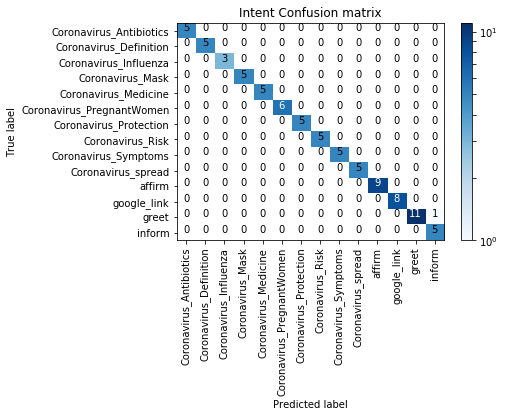

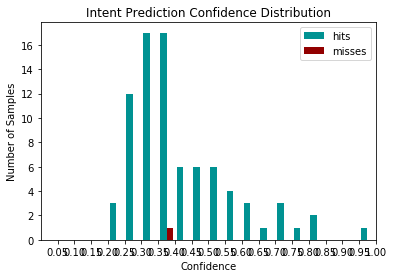

INFO:rasa_nlu.evaluate:Entity evaluation results:
INFO:rasa_nlu.evaluate:Evaluation for entity extractor: ner_crf 
INFO:rasa_nlu.evaluate:F1-Score:  1.0
INFO:rasa_nlu.evaluate:Precision: 1.0
INFO:rasa_nlu.evaluate:Accuracy:  1.0
INFO:rasa_nlu.evaluate:Classification report: 
             precision    recall  f1-score   support

      group       1.00      1.00      1.00         6
  no_entity       1.00      1.00      1.00       502

avg / total       1.00      1.00      1.00       508



In [43]:
from rasa_nlu.evaluate import run_evaluation

run_evaluation("nlu.md", model_directory)

#Part 2: Handling the dialogue
We have taught our chatbot how to understand user inputs. Now, it's time to teach our chatbot how to make responses by training a dialogue management model using Rasa Core.

Writing Stories
The training data for dialogue management models is called stories. A story is an actual conversation where user inputs are expressed as intents as well as corresponding entities, and chatbot responses are expressed as actions.

Let's take a look into the format of the stories in more detail:

A story starts with ## and you can give it a name. Lines that start with * are messages sent by the user. Although you don't write the actual message, but rather the intent (and the entities) that represent what the user means. Lines that start with - are actions taken by your bot. In this case all of our actions are just messages sent back to the user, like utter_greet, but in general an action can do anything, including calling an API and interacting with the outside world.

In [44]:
stories_md = """
## path 1               
* greet
  - utter_greet             
* Coronavirus_Definition  
  - utter_action_Coronavirus_Definition
* Coronavirus_Symptoms
  - utter_action_Coronavirus_Symptoms
* affirm  
  - utter_affirm

## path 2               
* greet
  - utter_greet             
* Coronavirus_Nature  
  - utter_action_Coronavirus_Nature
* Coronavirus_Protection
  - utter_action_Coronavirus_Protection  
* google_link
  - utter_link
* affirm
  - utter_affirm

## path 3               
* greet
  - utter_greet             
* Coronavirus_Risk  
  - utter_action_Coronavirus_Risk
* Coronavirus_Antibiotics 
  - utter_action_Coronavirus_Antibiotics
* Coronavirus_Medicine
  - utter_action_Coronavirus_Medicine 
* google_link
  - utter_link
* affirm
  - utter_affirm  
  
## path 4               
* greet
  - utter_greet               
* Coronavirus_Influenza
  - utter_action_Coronavirus_Influenza
* affirm
  - utter_affirm  

## path 5               
* greet
  - utter_greet             
* Coronavirus_Mask 
  - utter_action_Coronavirus_Mask
* google_link
  - utter_link  
* affirm
  - utter_affirm   
  

## path 6               
* greet
  - utter_greet             
* Coronavirus_PregnantWomen  
  - utter_action_Coronavirus_PregnantWomen 
* affirm
  - utter_affirm  

## path 7              
* greet
  - utter_greet             
* Coronavirus_Definition  
  - utter_action_Coronavirus_Definition 
* affirm
  - utter_affirm

## path 8               
* greet
  - utter_greet             
* Coronavirus_Symptoms
  - utter_action_Coronavirus_Symptoms 
* affirm
  - utter_affirm

## path 9               
* greet
  - utter_greet             
* Coronavirus_Nature  
  - utter_action_Coronavirus_Nature
* affirm
  - utter_affirm

## path 10               
* greet
  - utter_greet             
* Coronavirus_Protection
  - utter_action_Coronavirus_Protection 
* affirm
  - utter_affirm

## path 11               
* greet
  - utter_greet             
* Coronavirus_Risk  
  - utter_action_Coronavirus_Risk 
* affirm
  - utter_affirm

## path 12              
* greet
  - utter_greet             
* Coronavirus_Antibiotics 
  - utter_action_Coronavirus_Antibiotics 
* affirm
  - utter_affirm

## path 13               
* greet
  - utter_greet             
* Coronavirus_Medicine
  - utter_action_Coronavirus_Medicine 
* affirm
  - utter_affirm

## path 14               
* greet
  - utter_greet             
* Coronavirus_Definition  
  - utter_action_Coronavirus_Definition
* Coronavirus_Symptoms
  - utter_action_Coronavirus_Symptoms
* Coronavirus_Nature  
  - utter_action_Coronavirus_Nature
* Coronavirus_Protection
  - utter_action_Coronavirus_Protection
* Coronavirus_Risk  
  - utter_action_Coronavirus_Risk
* Coronavirus_Antibiotics 
  - utter_action_Coronavirus_Antibiotics
* Coronavirus_Medicine
  - utter_action_Coronavirus_Medicine
* Coronavirus_Influenza
  - utter_action_Coronavirus_Influenza
* Coronavirus_Mask 
  - utter_action_Coronavirus_Mask 
* Coronavirus_PregnantWomen  
  - utter_action_Coronavirus_PregnantWomen
* google_link
  - utter_link
* affirm
  - utter_affirm

## path 15               
* greet
  - utter_greet             
* Coronavirus_Definition  
  - utter_action_Coronavirus_Definition
* Coronavirus_Symptoms
  - utter_action_Coronavirus_Symptoms
* Coronavirus_Nature  
  - utter_action_Coronavirus_Nature
* Coronavirus_Protection
  - utter_action_Coronavirus_Protection
* Coronavirus_Risk  
  - utter_action_Coronavirus_Risk
* google_link
  - utter_link
* affirm
  - utter_affirm

## path 16               
* greet
  - utter_greet             
* Coronavirus_Antibiotics 
  - utter_action_Coronavirus_Antibiotics
* Coronavirus_Medicine
  - utter_action_Coronavirus_Medicine
* Coronavirus_Influenza
  - utter_action_Coronavirus_Influenza
* Coronavirus_Mask 
  - utter_action_Coronavirus_Mask 
* Coronavirus_PregnantWomen  
  - utter_action_Coronavirus_PregnantWomen 
* affirm
  - utter_affirm

## path 17              
* greet
  - utter_greet 
* Coronavirus_Risk  
  - utter_action_Coronavirus_Risk 
* Coronavirus_Protection
  - utter_action_Coronavirus_Protection
* Coronavirus_Nature  
  - utter_action_Coronavirus_Nature 
* Coronavirus_Symptoms
  - utter_action_Coronavirus_Symptoms          
* Coronavirus_Definition  
  - utter_action_Coronavirus_Definition 
* affirm
  - utter_affirm

## path 18             
* greet
  - utter_greet             
* Coronavirus_Definition  
  - utter_action_Coronavirus_Definition
* Coronavirus_Definition  
  - utter_action_Coronavirus_Definition
* Coronavirus_Definition  
  - utter_action_Coronavirus_Definition
* Coronavirus_Symptoms
  - utter_action_Coronavirus_Symptoms
* Coronavirus_Symptoms
  - utter_action_Coronavirus_Symptoms
* Coronavirus_Symptoms
  - utter_action_Coronavirus_Symptoms
* affirm
  - utter_affirm

## path 19             
* greet
  - utter_greet             
* Coronavirus_Symptoms
  - utter_action_Coronavirus_Symptoms
* Coronavirus_Symptoms
  - utter_action_Coronavirus_Symptoms
* google_link
  - utter_link
* affirm
  - utter_affirm

## path 20              
* greet
  - utter_greet
* Coronavirus_Definition  
  - utter_action_Coronavirus_Definition
* Coronavirus_Definition  
  - utter_action_Coronavirus_Definition
* affirm
  - utter_affirm

## path 21              
* greet
  - utter_greet             
* Coronavirus_Antibiotics 
  - utter_action_Coronavirus_Antibiotics 
* Coronavirus_Antibiotics 
  - utter_action_Coronavirus_Antibiotics
* affirm
  - utter_affirm

## path 22              
* greet
  - utter_greet             
* Coronavirus_Medicine
  - utter_action_Coronavirus_Medicine
* Coronavirus_Medicine
  - utter_action_Coronavirus_Medicine 
* affirm
  - utter_affirm

## path 23              
* greet
  - utter_greet             
* Coronavirus_Mask 
  - utter_action_Coronavirus_Mask
* Coronavirus_Mask 
  - utter_action_Coronavirus_Mask 
* affirm
  - utter_affirm

## path 24              
* greet
  - utter_greet             
* Coronavirus_Risk  
  - utter_action_Coronavirus_Risk
* Coronavirus_Risk  
  - utter_action_Coronavirus_Risk
* affirm
  - utter_affirm

## path 25              
* greet
  - utter_greet             
* Coronavirus_Definition  
  - utter_action_Coronavirus_Definition
* Coronavirus_Mask 
  - utter_action_Coronavirus_Mask 
* Coronavirus_Antibiotics 
  - utter_action_Coronavirus_Antibiotics
* Coronavirus_Medicine
  - utter_action_Coronavirus_Medicine
* Coronavirus_Symptoms
  - utter_action_Coronavirus_Symptoms
* Coronavirus_Nature  
  - utter_action_Coronavirus_Nature
* Coronavirus_PregnantWomen  
  - utter_action_Coronavirus_PregnantWomen 
* Coronavirus_Protection
  - utter_action_Coronavirus_Protection
* Coronavirus_Risk  
  - utter_action_Coronavirus_Risk
* Coronavirus_Influenza
  - utter_action_Coronavirus_Influenza 
* affirm
  - utter_affirm
              
"""

%store stories_md > stories.md

Writing 'stories_md' (str) to file 'stories.md'.


#Defining a Domain
The domain specifies the universe that the bot operates in. In chatbot's world this universe consists of intents and entities as well as the actions which appear in training stories. The domain can also contain the templates for the answers a chabot should use to respond to the user and slots which will help the chatbot to keep track of the context. Let's look into the domain of our bot:

In [45]:
domain_yml = """
intents:
- greet
- Coronavirus_Definition
- Coronavirus_Symptoms
- Coronavirus_Nature
- Coronavirus_Protection
- Coronavirus_Risk
- Coronavirus_Antibiotics
- Coronavirus_Medicine
- Coronavirus_Mask
- Coronavirus_PregnantWomen
- Coronavirus_Influenza
- google_link
- affirm

  
entities:
- Coronavirus
- Symptoms
- Nature
- Protection
- SARS
- Influenza


actions:
- utter_greet
- utter_action_Coronavirus_Definition
- utter_action_Coronavirus_Symptoms
- utter_action_Coronavirus_Nature
- utter_action_Coronavirus_Protection
- utter_action_Coronavirus_Risk
- utter_action_Coronavirus_Antibiotics
- utter_action_Coronavirus_Medicine
- utter_action_Coronavirus_Mask
- utter_action_Coronavirus_PregnantWomen
- utter_action_Coronavirus_Influenza
- utter_link
- utter_affirm
- __main__.ApiAction

templates:
  utter_greet:
  - text: "Hello, I can offer you assistance on COVID-19 queries, how can I help you?"
  utter_action_Coronavirus_Definition:
  - text: "Coronaviruses are a large family of viruses which may cause illness in animals or humans."
  - text: "In humans, several coronaviruses are known to cause respiratory infections ranging from the common cold to more severe diseases."
  - text: "COVID-19 is the infectious disease caused by the most recently discovered coronavirus. This new virus and disease were unknown before the outbreak began in Wuhan, China, in December 2019."
  utter_action_Coronavirus_Symptoms:
  - text: "The most common symptoms of COVID-19 are fever, tiredness, and dry cough. Some patients may have aches and pains, nasal congestion, runny nose, sore throat or diarrhea. These symptoms are usually mild and begin gradually."
  - text: "Some people become infected but don't develop any symptoms and don't feel unwell. Most people (about 80%) recover from the disease without needing special treatment."
  - text: "Around 1 out of every 6 people who gets COVID-19 becomes seriously ill and develops difficulty breathing."
  - text: "Older people, and those with underlying medical problems like high blood pressure, heart problems or diabetes, are more likely to develop serious illness. People with fever, cough and difficulty breathing should seek medical attention." 
  utter_action_Coronavirus_Nature:
  - text: "People can catch COVID-19 from others who have the virus. The disease can spread from person to person through small droplets from the nose or mouth which are spread when a person with COVID-19 coughs or exhales."
  - text: "People can also catch COVID-19 if they breathe in droplets from a person with COVID-19 who coughs out or exhales droplets. This is why it is important to stay more than 1 meter (3 feet) away from a person who is sick."
  - text: "Studies to date suggest that the virus that causes COVID-19 is mainly transmitted through contact with respiratory droplets rather than through the air."
  - text: "The main way the disease spreads is through respiratory droplets expelled by someone who is coughing. The risk of catching COVID-19 from someone with no symptoms at all is very low."
  - text: "Many people with COVID-19 experience only mild symptoms. This is particularly true at the early stages of the disease. It is therefore possible to catch COVID-19 from someone who has, for example, just a mild cough and does not feel ill."
  - text: "The risk of catching COVID-19 from the feces of an infected person appears to be low. While initial investigations suggest the virus may be present in feces in some cases, spread through this route is not a main feature of the outbreak." 
  utter_action_Coronavirus_Protection:
  - text: "The risk of catching COVID-19 from the feces of an infected person appears to be low. While initial investigations suggest the virus may be present in feces in some cases, spread through this route is not a main feature of the outbreak."
  - text: "Regularly and thoroughly clean your hands with an alcohol-based hand rub or wash them with soap and water."
  - text: "Maintain at least 1 metre (3 feet) distance between yourself and anyone who is coughing or sneezing."
  - text: "Avoid touching eyes, nose and mouth."
  - text: "Make sure you, and the people around you, follow good respiratory hygiene. This means covering your mouth and nose with your bent elbow or tissue when you cough or sneeze. Then dispose of the used tissue immediately."
  - text: "Stay home if you feel unwell. If you have a fever, cough and difficulty breathing, seek medical attention and call in advance. Follow the directions of your local health authority."
  - text: "If possible, avoid traveling to places  – especially if you are an older person or have diabetes, heart or lung disease."
  - text: "Keep up to date on the latest COVID-19 hotspots (cities or local areas where COVID-19 is spreading widely)."
  - text: "Self-isolate by staying at home if you begin to feel unwell, even with mild symptoms such as headache, low grade fever (37.3 C or above) and slight runny nose, until you recover."
  - text: "If you develop fever, cough and difficulty breathing, seek medical advice promptly as this may be due to a respiratory infection or other serious condition. Call in advance and tell your provider of any recent travel or contact with travelers."
  utter_action_Coronavirus_Risk:
  - text: "The risk depends on where you  are - and more specifically, whether there is a COVID-19 outbreak unfolding there."
  - text: "For most people in most locations the risk of catching COVID-19 is still low. However, there are now places around the world (cities or areas) where the disease is spreading. For people living in, or visiting, these areas the risk of catching COVID-19 is higher."
  - text: "COVID-19 outbreaks can be contained and transmission stopped, as has been shown in China and some other countries. Unfortunately, new outbreaks can emerge rapidly. It's important to be aware of the situation where you are or intend to go."
  - text: "Illness due to COVID-19 infection is generally mild, especially for children and young adults. However, it can cause serious illness: about 1 in every 5 people who catch it need hospital care."
  - text: "We can channel our concerns into actions to protect ourselves, our loved ones and our communities."
  - text: "While we are still learning about how COVID-2019 affects people, older persons and persons with pre-existing medical conditions (such as high blood pressure, heart disease, lung disease, cancer or diabetes)  appear to develop serious illness more often than others."
  utter_action_Coronavirus_Antibiotics:
  - text: "No. Antibiotics do not work against viruses, they only work on bacterial infections. COVID-19 is caused by a virus, so antibiotics do not work. "
  - text: "Antibiotics should not be used as a means of prevention or treatment of COVID-19. They should only be used as directed by a physician to treat a bacterial infection." 
  utter_action_Coronavirus_Medicine:
  - text: "vaccination will be available soon"
  - text: "vaccine is still not available for covid-19"
  - text: "While some western, traditional or home remedies may provide comfort and alleviate symptoms of COVID-19, there is no evidence that current medicine can prevent or cure the disease. "
  - text: "WHO does not recommend self-medication with any medicines, including antibiotics, as a prevention or cure for COVID-19."
  - text: "Not yet. To date, there is no vaccine and no specific antiviral medicine to prevent or treat COVID-2019. "
  - text: "Those affected should receive care to relieve symptoms. People with serious illness should be hospitalized. Most patients recover thanks to supportive care."
  - text: "Possible vaccines and some specific drug treatments are under investigation. They are being tested through clinical trials. WHO is coordinating efforts to develop vaccines and medicines to prevent and treat COVID-19."
  - text: "The most effective ways to protect yourself and others against COVID-19 are to frequently clean your hands, cover your cough with the bend of elbow or tissue, and maintain a distance of at least 1 meter (3 feet) from people who are coughing or sneezing."
  utter_action_Coronavirus_Mask:
  - text: "Only wear a mask if you are ill with COVID-19 symptoms (especially coughing) or looking after someone who may have COVID-19. Disposable face mask can only be used once."
  - text: "If you are not ill or looking after someone who is ill then you are wasting a mask. "
  - text: "There is a world-wide shortage of masks, so WHO urges people to use masks wisely."
  utter_action_Coronavirus_PregnantWomen:
  - text: "At present there is no evidence that they are at higher risk of severe illness than the general population."
  - text: "due to changes in their bodies and immune systems, we know that pregnant women can be badly affected by some respiratory infections. It is therefore important that they take precautions to protect themselves against COVID-19, and report possible symptoms (including fever, cough or difficulty breathing) to their healthcare provider."
  - text: "Pregnant women should take the same precautions to avoid COVID-19 infection as other people."
  - text: "Pregnant women and women who have recently delivered – including those affected by COVID-19 - should attend their routine care appointments. "
  - text: "Testing protocols and eligibility vary depending on where you live."
  - text: "We still do not know if a pregnant woman with COVID-19 can pass the virus to her foetus or baby during pregnancy or delivery. To date, the virus has not been found in samples of amniotic fluid or breastmilk."
  - text: "All pregnant women, including those with confirmed or suspected COVID-19 infections, have the right to high quality care before, during and after childbirth. "
  - text: "No. WHO advice is that caesarean sections should only be performed when medically justified."
  utter_action_Coronavirus_Influenza:
  - text: "COVID-19 and influenza viruses have a similar disease presentation. That is, they both cause respiratory disease, which presents as a wide range of illness from asymptomatic or mild through to severe disease and death."
  - text: "Both viruses are transmitted by contact, droplets and fomites."
  - text: "The speed of transmission is an important point of difference between the two viruses. Influenza has a shorter median incubation period (the time from infection to appearance of symptoms) and a shorter serial interval (the time between successive cases) than COVID-19 virus."
  - text: "Those most at risk for severe influenza infection are children, pregnant women, elderly, those with underlying chronic medical conditions and those who are immunosuppressed."
  - text: "Mortality for COVID-19 appears higher than for influenza, especially seasonal influenza."
  - text: "While there are a number of therapeutics currently in clinical trials in China and more than 20 vaccines in development for COVID-19, there are currently no licensed vaccines or therapeutics for COVID-19."
  utter_affirm:
  - text: "You're welcome"
  utter_link:
  - "Here is some more information https://www.cdc.gov/coronavirus/2019-ncov/index.html , hope you have found this useful"
  - "Here is some more information https://www.cdc.gov/coronavirus/2019-ncov/symptoms-testing/symptoms.html , hope you have found this useful"
  - "Here is some more information https://www.who.int/health-topics/coronavirus#tab=tab_1 , hope you have found this useful"
"""

%store domain_yml > domain.yml

Writing 'domain_yml' (str) to file 'domain.yml'.


In [46]:

from rasa_core.actions import Action
from rasa_core.events import SlotSet
from IPython.core.display import Image, display

import requests

In [47]:
class ApiAction(Action):
    
    def name(self):
        return "action_retrieve_link"
    
    def run(self, dispatcher, tracker, domain):
        
        group = tracker.get_slot('group')
        
        r = requests.get('https://www.google.com/'.format(group))
        response = r.content.decode()
        response = response.replace('["',"")
        response = response.replace('"]',"")
   
        
        #display(Image(response[0], height=550, width=520))
        dispatcher.utter_message("Here is the link for more information: {}".format(response))

#Adding Custom Actions
The responses of the chatbot can be more than just simple text responses - we can call an API to retrieve some data which can later be used to create a response to user input. Let's create a custom action for our bot which, when predicted, will make an API and retrieve a picture of a dog, a cat or a bird, depending on which was specified by the user. The bot will know which type of picture should be received by retrieving the value of the slot group.

In [48]:
from IPython.display import Image
from rasa_core.agent import Agent

#Training your Dialogue Model
Now we are good to train the dialogue management model. We can specify what policies should be used to train it - in this case, the model is a neural network implemented in Keras which learns to predict which action to take next. We can also tweak the parameters of what percentage of training examples should be used for validation and how many epochs should be used for training.

In [49]:
from rasa_core.policies import FallbackPolicy, KerasPolicy, MemoizationPolicy
#from rasa_core.agent import Agent

In [50]:
import warnings
warnings.simplefilter('ignore')

In [51]:
from rasa_core.policies import KerasPolicy, MemoizationPolicy
from rasa_core.agent import Agent

agent = Agent('domain.yml', policies=[MemoizationPolicy(), KerasPolicy()])

# loading our neatly defined training dialogues
training_data = agent.load_data('stories.md')

agent.train(
    training_data,
    validation_split=0.1,
    epochs=500
)

agent.persist('models/dialogue')

Processed Story Blocks: 100%|██████████| 25/25 [00:00<00:00, 129.04it/s, # trackers=14]
Processed actions: 197it [00:00, 780.65it/s, # examples=197]
INFO:rasa_core.policies.keras_policy:Fitting model with 197 total samples and a validation split of 0.1


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 5, 36)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8832      
_________________________________________________________________
dense (Dense)                (None, 17)                561       
_________________________________________________________________
activation (Activation)      (None, 17)                0         
Total params: 9,393
Trainable params: 9,393
Non-trainable params: 0
_________________________________________________________________
Train on 177 samples, validate on 20 samples
Epoch 1/500
177/177 [==============================] - 1s 5ms/step - loss: 2.7972 - acc: 0.2147 - val_loss: 2.7572 - val_acc: 0.3500
Epoch 2/500
177/177 [==============================] - 0s 390us/step - loss: 2.7091 - acc: 0.4

INFO:rasa_core.policies.keras_policy:Done fitting keras policy model
INFO:rasa_core.agent:Model directory models/dialogue exists and contains old model files. All files will be overwritten.
INFO:rasa_core.agent:Persisted model to '/content/models/dialogue'


In [52]:
from rasa_core.agent import Agent
from rasa_core.interpreter import NaturalLanguageInterpreter

interpreter = NaturalLanguageInterpreter.create(model_directory)
agent = Agent.load('models/dialogue', interpreter=interpreter)

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.


In [54]:
name=input("Enter Your Name: ")
print("Welcome to COVID-19 Advisory chatbot service")
while True:
    a = input(name+':')
    if a =='Bye' or a =='bye':
        print('Bot: Bye, STAY HOME STAY SAFE!!, also maintain social distancing')
        break
    else:
        responses = agent.handle_text(a)
        for response in responses:
            print('Bot:',response["text"])

Enter Your Name: pushya
Welcome to COVID-19 Advisory chatbot service
pushya:hi
Bot: Hello, I can offer you assistance on COVID-19 queries, how can I help you?
pushya:what is covid
Bot: Coronaviruses are a large family of viruses which may cause illness in animals or humans.
pushya:symptoms of covid
Bot: Older people, and those with underlying medical problems like high blood pressure, heart problems or diabetes, are more likely to develop serious illness. People with fever, cough and difficulty breathing should seek medical attention.
pushya:effect on pregnant women
Bot: Pregnant women should take the same precautions to avoid COVID-19 infection as other people.
pushya:tell me more
Bot: Here is some more information https://www.cdc.gov/coronavirus/2019-ncov/index.html , hope you have found this useful
pushya:thank you
Bot: You're welcome
pushya:bye
Bot: Bye, STAY HOME STAY SAFE!!, also maintain social distancing
